# Sensitivity Analysis: ASHRAE Guideline 14 Equations

*by Herman Carstens*

In this notebook we will explore the sensitivity of ASHRAE Guideline 14-2014 equations 4-7 and 4-8 to their input values. These equations describe the overall uncertainty of the savings estimate in an energy Measurement and Verification project. In the [ASHRAE Guideline 14-2002](http://esl.tamu.edu/docs/terp/2005/ESL-IC-05-10-50.pdf) these are equations 5-7 and 5-7.1. They are as follows:

## Equation 4-7:  In cases where baseline energy use or demand varies from period to period in response to known independent variables:

$$U = \frac{t}{F} \sqrt{\frac{CV(RMSE)^2}{m} \times \left[\frac{n}{n'} \left(1.6+\frac{3.2}{n'}\right)\right] +U_s^2 + RE^2_{instrument} + U^2_{iv}}$$

## Equation 4-8: No sampling, utility bills as data, official weather data

$$U = t \times \frac{1.26 \times CVRMSE}{F} \times \sqrt{\frac{n + 2}{n \times m}}$$

where:

$U$: Relative uncertainty in reported savings, expressed as a percentage.

CV(RMSE): Coefficient of Variation on the Room Mean Square Error:
$$CVRMSE = \frac{\sqrt{\frac{\Sigma (y_i-\hat y_i)^2}{n-p}}}{\bar y}.$$

t: _t_-statistic determined at $p=1$.

$F$: Fractional savings. Approximate percentage of savings achieved relative to baseline. 

Note:
Note that CV(RMSE) represents all the baseline model uncertainty - with the following limits: ASHRAE 4.3.2.1. Prescriptive path: CV(RMSE) < 25% if there are 12 months in the reporting period. This is based on a minimum sample size of n = 9. ASHRAE 4.3.2.2. Performance path: CV(RSME) not specified, but total uncertainty U < 50% at confidence level 68%. Also excluded data must be less than 25% of baseline data.

[....this aspect is going to require some discussion .....]

IPMVP and ASHRAE do not deal adequately with model verification and validation (hence the inclusion of sections 3, 4, 5, and 6 of this guideline). 

$U_s$: Sampling Uncertainty:

$$U_s = \frac{100}{\bar y} \times \sqrt{\left(1-\frac{q}{Q}\right)\left[\sum_{i=1}^{n}(y_i-\bar y)^2/(q-1)\right]/q}$$.

$q$: size of random sample.

$Q$: Population size.

$m$: number of periods in baseline (months, weeks, days).

$\bar y$: Arithmetic mean of sampling observations.

$\hat y$: model's predicted value at $y$.

$n$: Number of post-retrofit reporting periods.

$n'$ Number of independent observations in a total of _n_ observations during baseline period, calculated as:

$$n' = n \times \frac{1-\rho}{1 + \rho}$$.

where $\rho$ is the autocorrelation coefficient  of a series of _n_ observations at lag 1, derived from performing a regression of the series of _n_ observations against the same data series offset by one time step. The lag-1 autocorrelation coefficient, as given by ASHRAE, is as follows:

$$\rho = \sqrt{1-\left[ \frac{\sum_{i=1}^{n} (y_i-\hat y)^2}{\sum_{i=1}^{n} (y_i-\bar y)^2}\right]}$$.

Note that this formula is incorrect in the 2014 version.

For monthly data, this guideline permits an assumption that $\rho$ is 0, so $n'=n$.

$p$: number of parameters or terms in baseline regression model.

$RE_{instrument}$: Relative error of instrument, expressed as percentage. If multiple instruments are used in series, the overall precision can be calculated as follows, provided that the precisions are all expressed at the same confidence level:

$$ RE_{instrument} = \frac{\sqrt{\sum_{i=1}^{c} (RE_{instrument} \times r_{rating,i})^2}}{\sum_{i=1}^{C}\bar r_t}$$.

where $r_{rating}$ refers to the value relative to which the instrument precision is expressed.

$U_{iv}$: Postretrofit energy savings uncertainty due to independent variable measurement error, expressed as a percentage.



Some Python preliminaries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.analyze import morris
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

Now we define the equations above as functions. `_sensitivity` functions were added because the equations as defined in 4-7 and 4-8 contain hidden variables of interest that should be explicitly defined. These are discussed below.

In [2]:
def four_seven(t, F, CVRMSE, m, n, U_s, RE_instrument, U_iv, n_prime=0):
    '''
    Overall uncertainty expression
    
    t: t-statistic
    F: Fractional savings: expressed as a percentage out of 100
    CVRMSE: Baseline uncertainty relative to model uncertainty
    m: Number of periods in the baseline
    n: number of post-retrofit reporting points
    n_prime: Number of independent observations in a total of n observations
    during baseline period. n_prime=n for monthly data
    U_s: sampling uncertainty
    RE_instrument: relative precision of measurement equipment
    U_iv: Postretrofit energy savings uncertainty due to independent variable 
    measurement error, expressed as a percentage.
    '''
    
    return t/F*np.sqrt(CVRMSE**2/m*(n/n_prime*(1.6 + 3.2/n_prime)) + U_s**2 + RE_instrument**2 + U_iv**2)
    
def four_eight(t, F, CVRMSE, m, n):
    '''
    Equivalent to 4_7 for no sampling, and utility bills as data
    
    t: t-statistic
    CVRMSE: Baseline uncertainty relative to model uncertainty
    F: Fractional savings: expressed as a percentage out of 100
    n: number of post-retrofit reporting points
    m: Number of periods in the baseline
    '''
    return t*1.26*CVRMSE/F*np.sqrt((n + 2)/(n*m))    

def four_eight_sensitivity(conf, F, CVRMSE, m, n, p):
    '''
    Equivalent to 4_7 for no sampling, and utility bills as data
    
    t: t-statistic
    CVRMSE: Baseline uncertainty relative to model uncertainty
    F: Fractional savings: expressed as a percentage out of 100
    n: number of post-retrofit reporting points
    m: Number of periods in the baseline
    '''
    if n - p < 2:
        t = 1
    else:
        t = stats.t.interval(conf, n - p)[1]
    return t*1.26*CVRMSE/F*np.sqrt((n + 2)/(n*m)) 

def four_seven_sensitivity(conf, F, CVRMSE, m, n, RE_instrument, U_iv, rho=1, CV=0.5, Q=100, theta=0.1, p=2):
    '''
    Overall uncertainty expression
    
    conf: confidence level
    F: Fractional savings: expressed as a percentage out of 100
    CVRMSE: Baseline uncertainty relative to model uncertainty
    m: Number of periods in the baseline
    n: number of post-retrofit reporting points
    rho: autocorrelation factor
    during baseline period. n_prime=n for monthly data
    U_s: sampling uncertainty
    RE_instrument: relative precision of measurement equipment
    U_iv: Postretrofit energy savings uncertainty due to independent variable 
    measurement error, expressed as a percentage.
    '''
    
    U_s_value = U_s_sensitivity(Q, theta, CV)
    #print('U_s_value: ', U_s_value)
    n_prime = n*(1 - rho)/(1 + rho)
    #print('n_prime: ', n_prime)
    #print('Q: ', Q)
    #q = np.ceil(Q*theta)
    #print('q: ', q)
    #print('t_stat: ', t_stat(q, 2, conf)) 
    if n - p <= 2:
        t = 1
    else:
        t =  stats.t.interval(conf, n - p)[1]
        
    return t/F*np.sqrt(CVRMSE**2/m*(n/n_prime*(1.6 + 3.2/n_prime)) + U_s_value**2 + RE_instrument**2 + U_iv**2)

def U_s_sensitivity(Q, theta, CV):
    '''
    Sampling uncertainty calculation
    Q: Population size
    theta: proportion of the population sampled
    q: sample size (derived from theta and Q)
    CV: coefficient of variance on the population
    '''
    q = np.ceil(Q*theta)
    return CV/np.sqrt(q)*np.sqrt(1 - theta)   
        
def U_s(data, q, Q):
    '''
    Sampling uncertainty calculation
    q: size of random sample
    Q: Population size
    '''
    
    data_mean = np.mean(data)
    return 100/data_mean*np.sqrt(np.sum((1 - q/Q)*(np.sum((data - data_mean)**2)/(q - 1)))/q)
    
def CVRMSE(data, model, p):
    n = len(data)
    return np.sqrt(sum((data - model)**2)/(n - p))/np.mean(data)
    
def CVSTD(data):
    n = len(data)
    data_mean = np.mean(data)
    return np.sqrt(np.sum((data-data_mean)**2)/(n - 1))/data_mean
    
def autocorrel(data, model):
    return np.sqrt(1 - np.sum((data - model)**2)/np.sum((data - np.mean(data))**2))
    
def n_prime_calc(data, model):
    n = len(model)
    return n*(1 - autocorrel(data, model))/(1 + autocorrel(data, model))

def t_stat(n, p, confidence):
    '''
    Calculate t-statistic for
    n: number of samples
    p: number of parameter in model
    confidence: confidence level.
    '''
    return stats.t.interval(confidence, n - p)[1]

## Analysis of Equation 4-8

We'll start with the simpler equation: the case of utility bills (no measurement error), reliable weather data (no independend variable error), and full sampling (no sampling error). The equation is:

$$U = t \times \frac{1.26 \times CVRMSE}{F} \times \sqrt{\frac{n + 2}{n \times m}}$$

For the sensitivity analysis, we'll be using the [SALib](http://salib.readthedocs.io/en/latest/index.html) Python library. First we define the ranges of the input parameters of equation 4-8. There are six parameters: $t, F, CV(RMSE), m, n,$ and $p$. We define $t$ by defining the confidence levels rather that the $t$ statistic itself.

The fractional savings value $F$ is set to change between 0 and 50%.

CV(RMSE) values are set to change between 0 and 30%.

$m$ and $n$, the number of data points in the baseline and post-retrofit period, are set to 12-60, representing the monthly case. We will consider hourly data later.

For monthly data, we consider models with 2-5 parameters.

In [3]:
parameter_ranges = {
    'num_vars': 6,
    'names': ['conf', 'F', 'CVRMSE', 'm', 'n', 'p'],
    'bounds': [[0.68, 0.95],
               [0.0001, 0.5],
               [0.0001, 0.3],
               [12, 60],
               [12, 60],
               [2, 5]]
}

We will use the Sobol' method with Saltelli's sampling improvement. (The Morris method of sensitivity analysis is popular with energy researchers, and is also available in SALib.)

In [4]:
param_values = saltelli.sample(parameter_ranges, 50000, calc_second_order=True)

Y = np.empty([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y[i] = four_eight_sensitivity(X[0], X[1], X[2], X[3], X[4], X[5])

Si = sobol.analyze(parameter_ranges, Y, print_to_console=False)

confidence 	 F 		 CVRMSE 	 m 		 n 		 p
5.15E-02 	 9.78E-01 	 2.01E-01 	 4.85E-02 	 8.06E-04 	 3.03E-06


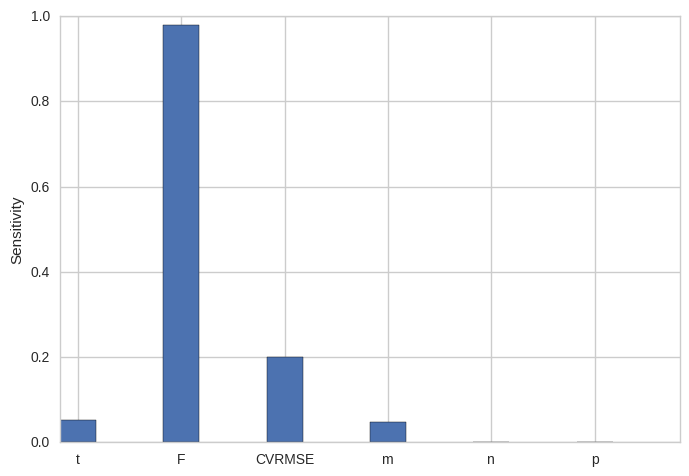

In [5]:
print('confidence \t', 'F \t\t', 'CVRMSE \t', 'm \t\t', 'n \t\t', 'p')
print('{:.2E}'.format(Si['ST'][0]), '\t', '{:.2E}'.format(Si['ST'][1]), '\t', '{:.2E}'.format(Si['ST'][2]), '\t', '{:.2E}'.format(Si['ST'][3]), '\t', '{:.2E}'.format(Si['ST'][4]), '\t', '{:.2E}'.format(Si['ST'][5]))

index = np.array([1, 2, 3, 4, 5, 6])
bar_width = 0.35
plt.bar(index, Si['ST'], bar_width)
plt.xticks(index + bar_width/2, ('confidence', 'F', 'CVRMSE', 'm', 'n', 'p'))
plt.ylabel('Sensitivity')

We can see that the fractional savings $F$ are the most important factor, but that CV(RMSE), confidence, and the number of reporting period data points are also important.

Considering now the hourly data case:

confidence 	 F 		 CVRMSE 	 m 		 n 		 p
4.67E-02 	 1.13E+00 	 2.25E-01 	 2.69E-01 	 5.71E-04 	 3.93E-05


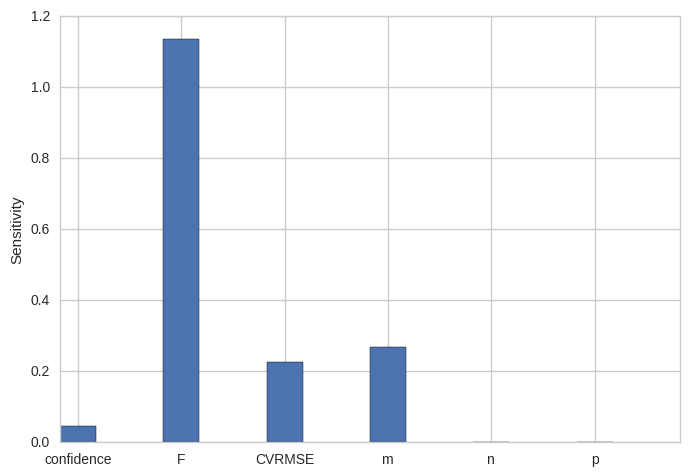

In [6]:
parameter_ranges = {
    'num_vars': 6,
    'names': ['conf', 'F', 'CVRMSE', 'm', 'n', 'p'],
    'bounds': [[0.68, 0.95],
               [0.0001, 0.5],
               [0.0001, 0.3],
               [24, 365*24],
               [24, 365*24],
               [2, 48*7+1]]
}

param_values = saltelli.sample(parameter_ranges, 50000, calc_second_order=True)

Y = np.empty([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y[i] = four_eight_sensitivity(X[0], X[1], X[2], X[3], X[4], X[5])

Si = sobol.analyze(parameter_ranges, Y, print_to_console=False)

print('confidence \t', 'F \t\t', 'CVRMSE \t', 'm \t\t', 'n \t\t', 'p')
print('{:.2E}'.format(Si['ST'][0]), '\t', '{:.2E}'.format(Si['ST'][1]), '\t', '{:.2E}'.format(Si['ST'][2]), '\t', '{:.2E}'.format(Si['ST'][3]), '\t', '{:.2E}'.format(Si['ST'][4]), '\t', '{:.2E}'.format(Si['ST'][5]))

index = np.array([1, 2, 3, 4, 5, 6])
bar_width = 0.35
plt.bar(index, Si['ST'], bar_width)
plt.xticks(index + bar_width/2, ('confidence', 'F', 'CVRMSE', 'm', 'n', 'p'))
plt.ylabel('Sensitivity')

Here we can see that for hourly data, CV(RMSE) becomes more important, but reporting period data points even more so.

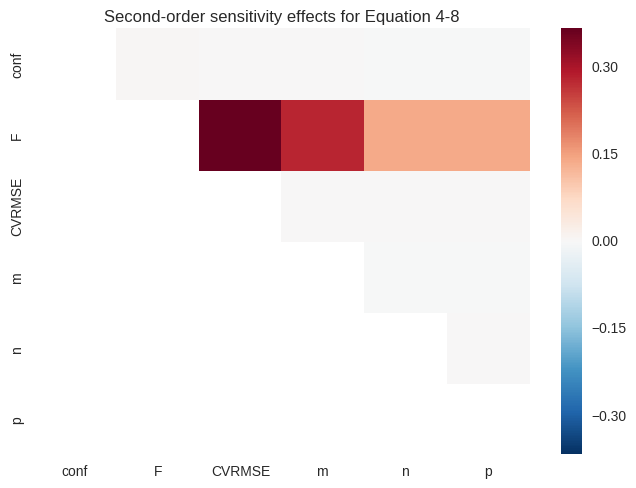

In [7]:
labels = ['conf', 'F', 'CVRMSE', 'm', 'n', 'p']
sns.heatmap(Si['S2'], xticklabels=labels, yticklabels=labels)
plt.title('Second-order sensitivity effects for Equation 4-8')

## Envelope determination

Next, let us plot the contours for the case of a 1-year baseline and 1 year reporting period data set reported at the 80% confidence level. The contour lines represent the uncertainty (precision) for a certain combination of CV(RMSE) and fractional savings:

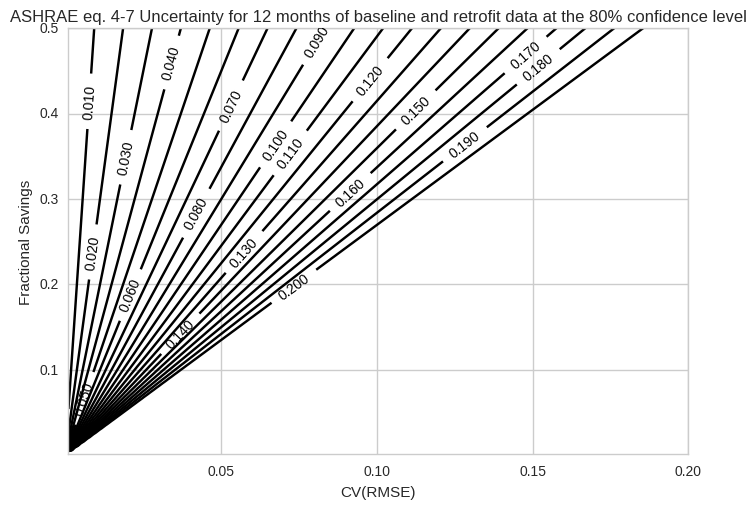

In [8]:
f = np.linspace(0.001, 0.5, 100)
c = np.linspace(0.001, 0.2, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_eight_sensitivity(0.8, F_var, C_var, m=12, n=12, p=2) for F_var in f] for C_var in c]
U = np.zeros([100, 100])

for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.21, 0.01)
F, C = np.meshgrid(f, c)        
CS = plt.contour(C, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CV(RMSE)')
plt.title('ASHRAE eq. 4-7 Uncertainty for 12 months of baseline and retrofit data at the 80% confidence level')

The linearity is to be expected, since $CV(RMSE)$ and fractional savings are outside the square root for equation 4-8. CV(RMSE) values of up to 18% are allowed at the 80/20 reporting level, but only with very high savings (50%). Once fractional savings drop to 30%, the maximum $CV(RMSE)$ allowed is around 11%.

To give an idea of what 11% $CV(RMSE)$ for monthly data looks like, see the figure below:

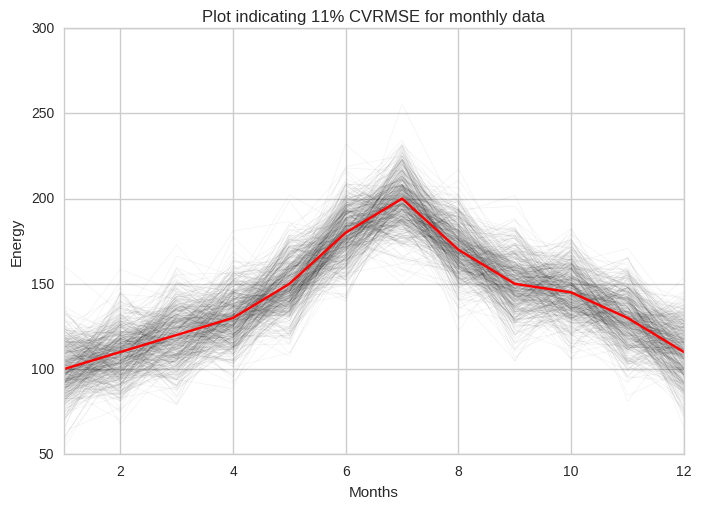

In [9]:
true_values = [100, 110, 120, 130, 150, 180, 200, 170, 150, 145, 130, 110]
x = np.arange(1,13,1)
cvrmse_record = np.zeros(500)
for i in range(500):
    model = np.random.normal(true_values, np.mean(true_values)*0.105)
    plt.plot(x, model, color='black', alpha=0.05, linewidth=0.5)
    cvrmse_record[i] = (CVRMSE(true_values, model, 2))
plt.plot(x, true_values, color='red')
plt.xlim([1,12])
plt.xlabel('Months')
plt.ylabel('Energy')
plt.title('Plot indicating 11% CVRMSE for monthly data')

What about if only 6 months of baseline data are available?

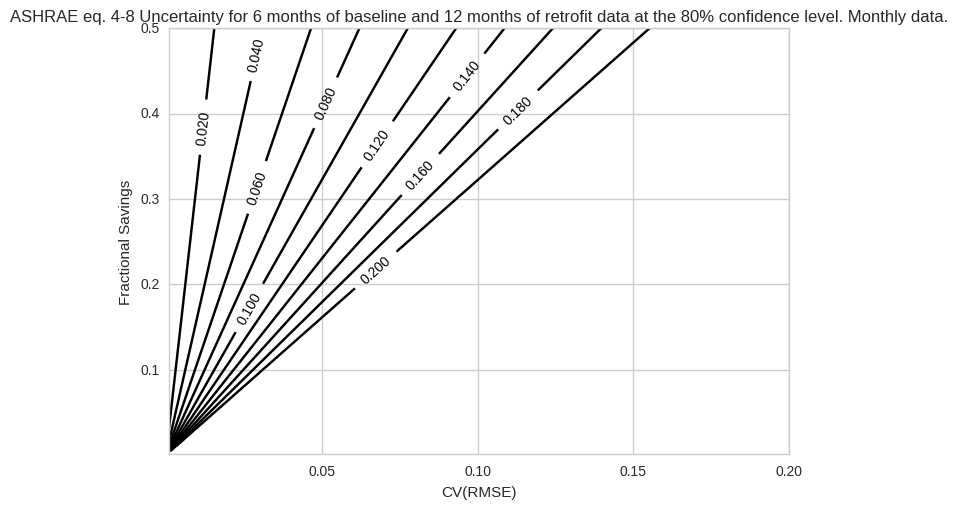

In [10]:
f = np.linspace(0.001, 0.5, 100)
c = np.linspace(0.001, 0.2, 100)
U_1 = [[four_eight_sensitivity(0.8, F_var, C_var, m=12, n=6, p=2) for F_var in f] for C_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.21, 0.02)
F, C = np.meshgrid(f, c)        
CS = plt.contour(C, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CV(RMSE)')
plt.title('ASHRAE eq. 4-8 Uncertainty for 6 months of baseline and 12 months of retrofit data at the 80% confidence level. Monthly data.')

One can see that the allowable $CV(RMSE)$ values are significantly reduced for this scenario. Even at 50% fractional savings, the maximum allowable $CV(RMSE)$ is about 15.5%. For 30% savings, the maximum allowable $CV(RMSE) at the 80/20 level is about 9%.

Let us now consider hourly data. Suppose we have 1 years' worth of hourly data in the baseline and reporting period:

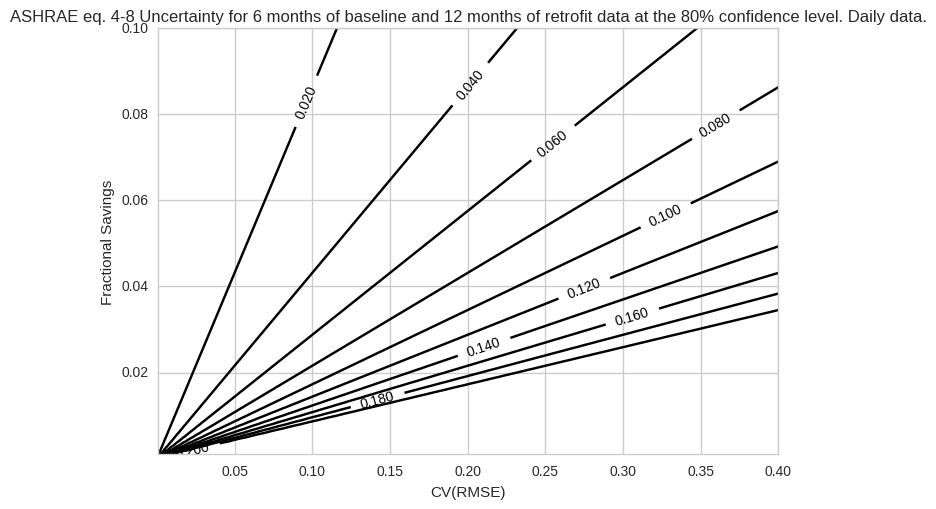

In [11]:
f = np.linspace(0.001, 0.1, 100)
c = np.linspace(0.001, 0.4, 100)
U_1 = [[four_eight_sensitivity(0.8, F_var, C_var, m=365*24, n=365*24, p=2) for F_var in f] for C_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.21, 0.02)
F, C = np.meshgrid(f, c)        
CS = plt.contour(C, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CV(RMSE)')
plt.title('ASHRAE eq. 4-8 Uncertainty for 6 months of baseline and 12 months of retrofit data at the 80% confidence level. Daily data.')

We can see that with so much data, only projects saving very small fractional savings with very large CV(RMSE)s need worry about not attaining the 80/20 confidence/precision limit.

Repeating the 6-month baseline calculation, we find:

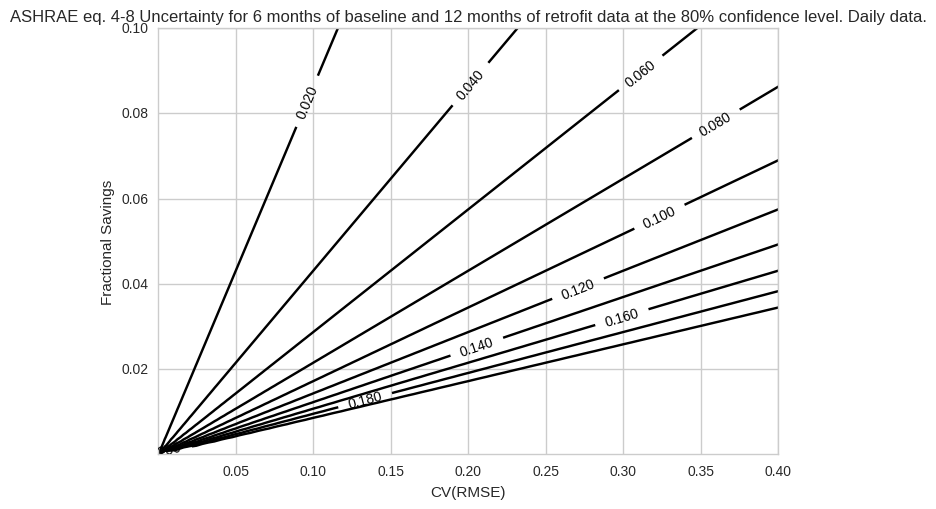

In [12]:
f = np.linspace(0.0001, 0.1, 100)
c = np.linspace(0.0001, 0.4, 100)
U_1 = [[four_eight_sensitivity(0.8, F_var, C_var, m=365*24, n=365*12, p=2) for F_var in f] for C_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.21, 0.02)
F, C = np.meshgrid(f, c)        
CS = plt.contour(C, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CV(RMSE)')
plt.title('ASHRAE eq. 4-8 Uncertainty for 6 months of baseline and 12 months of retrofit data at the 80% confidence level. Daily data.')

There is definitely less precision, but all still seems well.

## Analysis of Equation 4-7

We shall now consider the more complex equation in which measurement error, independent variable error, autocorrelation, and sampling may also play a role. The equation is:

$$U = \frac{t}{F} \sqrt{\frac{CV(RMSE)^2}{m} \times \left[\frac{n}{n'} \left(1.6+\frac{3.2}{n'}\right)\right] +U_s^2 + RE^2_{instrument} + U^2_{iv}}$$

Let us start with a sensitivity analysis once again. 

The ranges for $conf, F, CVRMSE, m, n$ and $p$ will stay the same as before. We expect instrument and independent variable errors $RE_{instrument}$ and $U_{iv}$ to be in the range $(0, 5\%)$. We note that the way ASHRAE handles these errors is incorrect, since to attenuation bias is considered. We will leave the equation as-is for this study.

$n'$ is more tricky, as it depends on the autocorrelation, which could be significant. We will specify $n'$ via $\rho$, and assume autocorrelations between 0 and 1. This means $n'$ will vary between 0 and $n$.

Similarly, we let the sampling uncertainty be calculated by specifying the sampling proportion as between 0 and 100%. 

The ASHRAE sampling uncertainty formula is:

$$U_s = \frac{100}{\bar y} \times \sqrt{\left(1-\frac{q}{Q}\right)\left[\sum_{i=1}^{n}(y_i-\bar y)^2/(q-1)\right]/q}.$$.

This is a different expression for the standard M&V sampling formula for normal distributions:

$$n = \frac{z^2 CV^2}{e^2},$$

where $e$ is precision (in this case equivalent to $U_s$. Note that $CV$ here is the *sampling $CV$*. That is, the coefficient of variation *between different samples*. Not the coefficient of variation of the data for each sample. 

We can now write

$$e = \frac{CV}{\sqrt{n}}.$$

The rearranged form of the ASHRAE $U_s$ equation, (with $z$ neglected as it is included in the overall $t$ term of eq. 4-7) is:

$$e = U_s = \frac{CV}{\sqrt{n}}\times \left(100\sqrt{1-\theta}\right).$$

where $\theta$ is the proportion of the population sampled. We can see that the ASHRAE equation simply takes the standard sampling equation, and multiplies the uncertainty by the square root of the proportion not sampled. It is only an approximation.

We see now that there is a hidden variable in the sampling uncertainty equation: $CV$. Instead of letting $q$ and $Q$ vary independently (creating scenarios where $q >Q$), we will specify $Q, \theta,$ and $CV$.

We will vary $CV$ between 0 and 1, the population size $Q$ between 2 and 100, and the proportion sampled $\theta$ between 0 and 1.

We have now specified all the parameters needed for the sensitivity analysis.

In [13]:
parameter_range = {
    'num_vars': 12,
    'names': ['conf','F', 'CVRMSE', 'm', 'n', 'RE_instrument', 'U_iv', 'rho', 'CV', 'Q', 'theta', 'p'],
    'bounds': [[0.68, 0.95],
               [0.0001, 0.5],
               [0.0001, 0.5],
               [12, 60],
               [12, 60],
               [0.0001, 0.05],
               [0.0001, 0.05],
               [0.0001, 0.99],
               [0.0001, 1],
               [2, 100],
               [0.1, 1],
               [2, 5]]
}

param_values = saltelli.sample(parameter_range, 50000, calc_second_order=True)

Y = np.empty([param_values.shape[0]])

for i, X in enumerate(param_values):    
    Y[i] = four_seven_sensitivity(X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[11])

Si = sobol.analyze(parameter_range, Y, print_to_console=False)

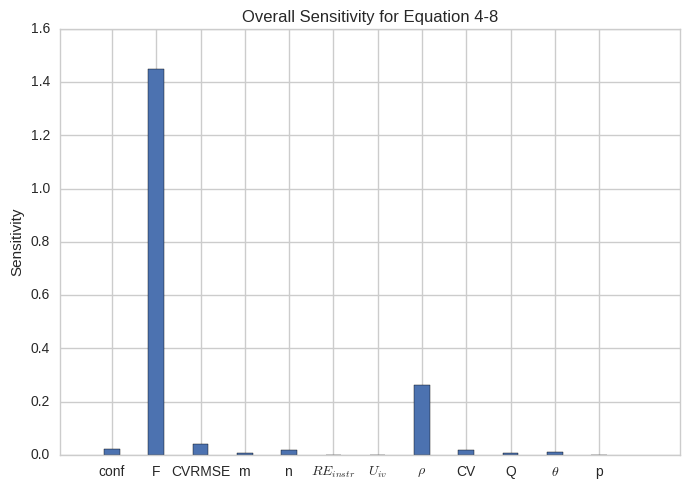

In [14]:
index = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
bar_width = 0.35
plt.bar(index, Si['ST'], bar_width)
plt.xticks(index + bar_width/2, ('conf', 'F', 'CVRMSE', 'm', 'n', r'$RE_{instr}$', r'$U_{iv}$', r'$\rho$', 'CV', 'Q', r'$\theta$', 'p'))
plt.ylabel('Sensitivity')
plt.title('Overall Sensitivity for Equation 4-8')

Here we can see that $\rho$ (the autocorrelation coefficient) also plays a role. 

The degrees of freedom for the $t$-statistic are given by ASHRAE as $n - p$. The number of reporting points during the baseline period minus the the number of parameters in the model. However, the number of samples $q$ are not considered. The $t$ statistic is therefore constant, whether 1 or 100 facilities are considered. Maybe I am wrong - my statistical knowledge is letting me down here - but this doesn't seem quite right.

Next, let us plot the second-order interactions:

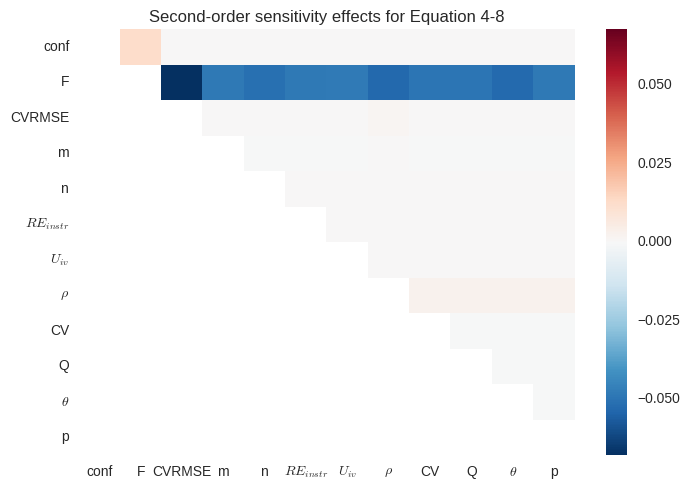

In [15]:
labels = ['conf', 'F', 'CVRMSE', 'm', 'n', r'$RE_{instr}$', r'$U_{iv}$', r'$\rho$', 'CV', 'Q', r'$\theta$', 'p']
sns.heatmap(Si['S2'], xticklabels=labels, yticklabels=labels)
plt.title('Second-order sensitivity effects for Equation 4-8')

It is worthwhile repeating the sensitivity analysis for hourly data. For hourly data models, there are often many parameters. For example, the time-of-day and temperature model is quite accurate, but has temperature as a continuous variable, and $48 \times 7$ categorical variables for the time of week.

In [16]:
parameter_range = {
    'num_vars': 12,
    'names': ['conf','F', 'CVRMSE', 'm', 'n', 'RE_instrument', 'U_iv', 'rho', 'CV', 'Q', 'theta', 'p'],
    'bounds': [[0.68, 0.95],
               [0.0001, 0.5],
               [0.0001, 0.5],
               [24, 24*365],
               [24, 24*365],
               [0.0001, 0.05],
               [0.0001, 0.05],
               [0.0001, 0.99],
               [0.0001, 1],
               [2, 100],
               [0.1, 1],
               [2, 48*7 + 1]]
}

param_values = saltelli.sample(parameter_range, 100000, calc_second_order=True)

Y = np.empty([param_values.shape[0]])

for i, X in enumerate(param_values):    
    Y[i] = four_seven_sensitivity(X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[11])

Si = sobol.analyze(parameter_range, Y, print_to_console=False)

The total sensitivities are notable for being slightly different than for the monthly case:

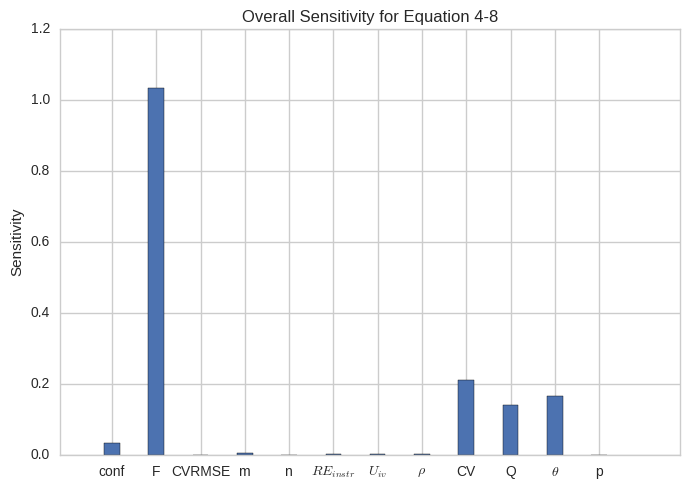

In [17]:
index = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
bar_width = 0.35
plt.bar(index, Si['ST'], bar_width)
plt.xticks(index + bar_width/2, ('conf', 'F', 'CVRMSE', 'm', 'n', r'$RE_{instr}$', r'$U_{iv}$', r'$\rho$', 'CV', 'Q', r'$\theta$', 'p'))
plt.ylabel('Sensitivity')
plt.title('Overall Sensitivity for Equation 4-8')

Interestingly the sampling uncertainty now becomes important, but the parameters that were altered ($m, n, p$) are not. $CV(RMSE) importance has also declined. The second-order interactive effects are as follows:

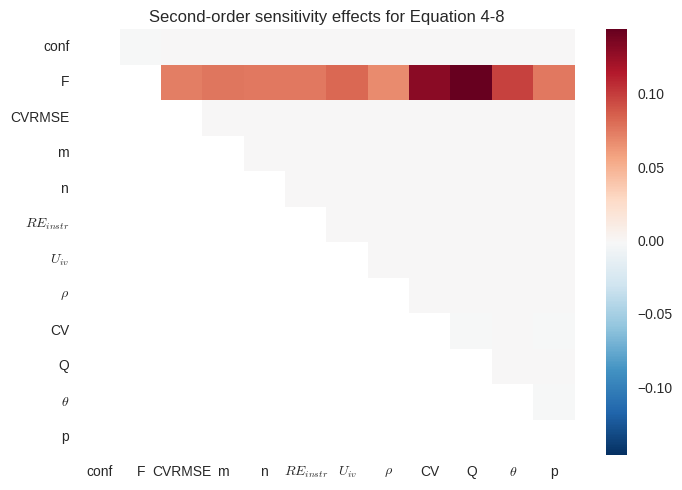

In [18]:
labels = ['conf', 'F', 'CVRMSE', 'm', 'n', r'$RE_{instr}$', r'$U_{iv}$', r'$\rho$', 'CV', 'Q', r'$\theta$', 'p']
sns.heatmap(Si['S2'], xticklabels=labels, yticklabels=labels)
plt.title('Second-order sensitivity effects for Equation 4-8')

## Envelope determination

Repeating these calculations for daily data rather than monthly data doesn't change the result as much. $CV, q, $ and $\theta$ become the significant second-tier parameters, but $F$ still dominates.

Now some envelope plots. There are too many variables to plot at once, but some common scenarios are considered below.

### 1Y baseline and retrofit monthly data, population size=1, 1% instrument and independent variable error

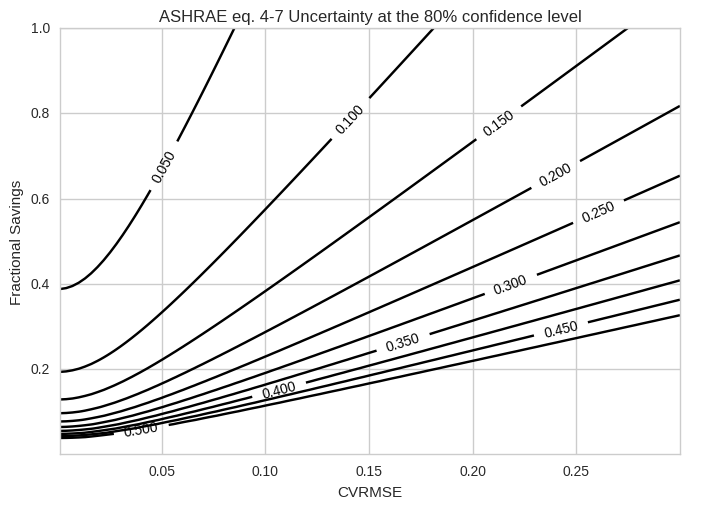

In [19]:
f = np.linspace(0.001, 1, 100)
c = np.linspace(0.001, 0.3, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_seven_sensitivity(conf=0.8, F=F_var, CVRMSE=c_var, m=12, n=12, RE_instrument=0.01, U_iv=0.01, rho=0, CV=0.5, Q=1, theta=1, p=2) for F_var in f] for c_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.51, 0.05)
F, RHO = np.meshgrid(f, c)
CS = plt.contour(RHO, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CVRMSE')
plt.title('ASHRAE eq. 4-7 Uncertainty at the 80% confidence level')

### 6 months baseline, 1Y retrofit monthly data, population size=1, 1% instrument and independent variable error

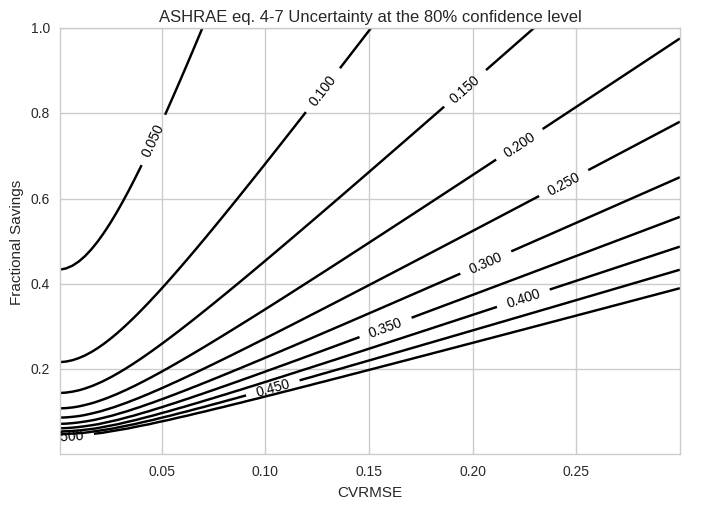

In [20]:
f = np.linspace(0.001, 1, 100)
c = np.linspace(0.001, 0.3, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_seven_sensitivity(conf=0.8, F=F_var, CVRMSE=c_var, m=12, n=6, RE_instrument=0.01, U_iv=0.01, rho=0, CV=0.5, Q=1, theta=1, p=2) for F_var in f] for c_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.51, 0.05)
F, RHO = np.meshgrid(f, c)
CS = plt.contour(RHO, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CVRMSE')
plt.title('ASHRAE eq. 4-7 Uncertainty at the 80% confidence level')

### 1Y baseline and retrofit monthly data, population size=1, 1% instrument and independent variable error, autocorrelation = 0.5

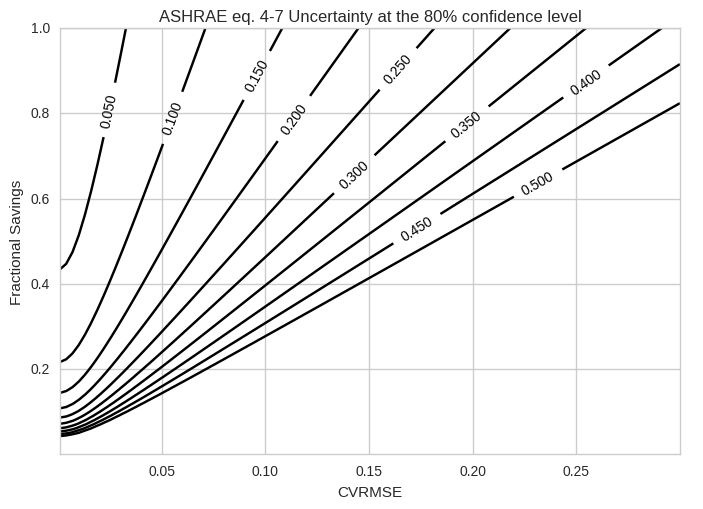

In [21]:
f = np.linspace(0.001, 1, 100)
c = np.linspace(0.001, 0.3, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_seven_sensitivity(conf=0.8, F=F_var, CVRMSE=c_var, m=12, n=6, RE_instrument=0.01, U_iv=0.01, rho=0.5, CV=0.5, Q=1, theta=1, p=2) for F_var in f] for c_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.51, 0.05)
F, RHO = np.meshgrid(f, c)
CS = plt.contour(RHO, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CVRMSE')
plt.title('ASHRAE eq. 4-7 Uncertainty at the 80% confidence level')

### 1Y baseline and retrofit monthly data, population size=1, 1% instrument and independent variable error, autocorrelation = 0, confidence=95%

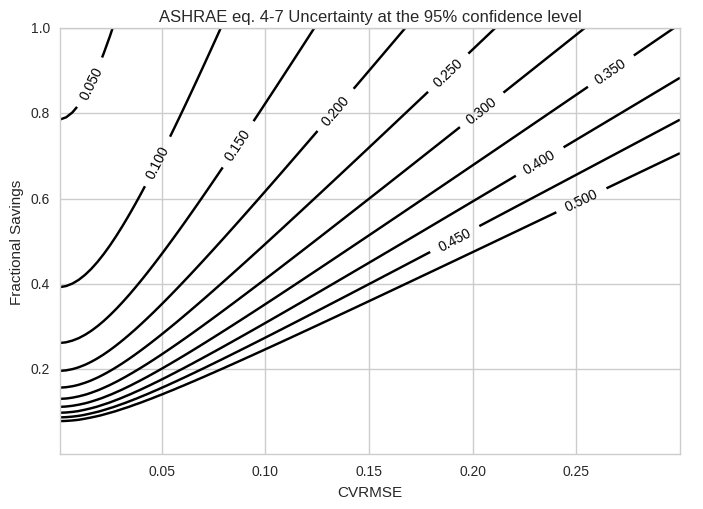

In [22]:
f = np.linspace(0.001, 1, 100)
c = np.linspace(0.001, 0.3, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_seven_sensitivity(conf=0.95, F=F_var, CVRMSE=c_var, m=12, n=6, RE_instrument=0.01, U_iv=0.01, rho=0, CV=0.5, Q=1, theta=1, p=2) for F_var in f] for c_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.51, 0.05)
F, RHO = np.meshgrid(f, c)
CS = plt.contour(RHO, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CVRMSE')
plt.title('ASHRAE eq. 4-7 Uncertainty at the 95% confidence level')

### 1 Year's baseline and retrofit daily data, population size=1, 1% instrument and independent variable error, no autocorrelation

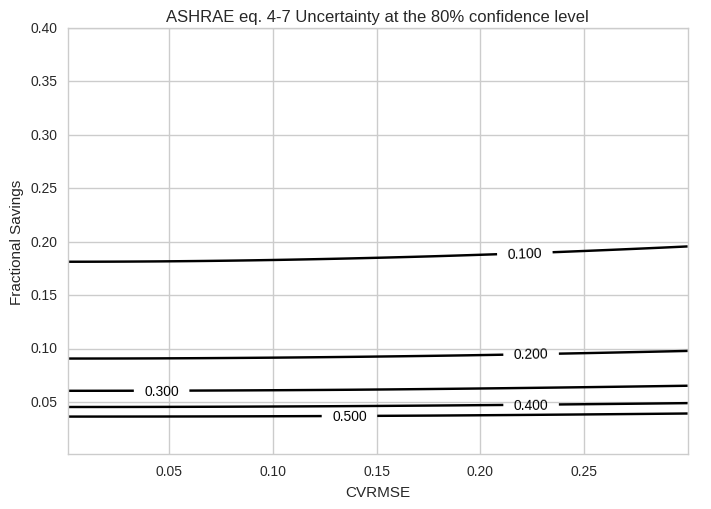

In [23]:
f = np.linspace(0.001, 0.4, 100)
c = np.linspace(0.001, 0.3, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_seven_sensitivity(conf=0.8, F=F_var, CVRMSE=c_var, m=12*365, n=12*365, RE_instrument=0.01, U_iv=0.01, rho=0, CV=0.5, Q=1, theta=1, p=2) for F_var in f] for c_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.51, 0.1)
F, RHO = np.meshgrid(f, c)
CS = plt.contour(RHO, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CVRMSE')
plt.title('ASHRAE eq. 4-7 Uncertainty at the 80% confidence level')

### 1 Year's baseline and retrofit daily data, population size=50, sample size 10, 3% instrument and 5% independent variable error, autocorrelation 0.2, time-of-week and temperature regression model

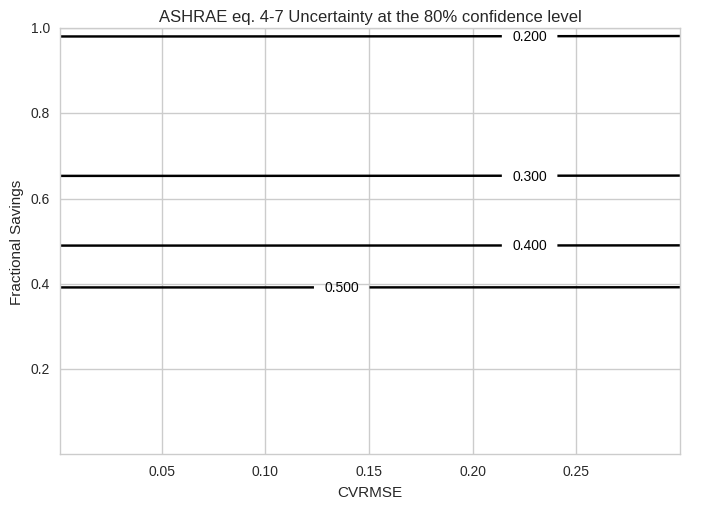

In [24]:
f = np.linspace(0.001, 1, 100)
c = np.linspace(0.001, 0.3, 100)
t_stat_value = t_stat(12, 2, 0.8)
U_1 = [[four_seven_sensitivity(conf=0.8, F=F_var, CVRMSE=c_var, m=12*365, n=12*365, RE_instrument=0.03, U_iv=0.05, rho=0.2, CV=0.5, Q=50, theta=0.2, p=7*48 + 1) for F_var in f] for c_var in c]
U = np.zeros([100, 100])
for i in range(len(U)):
    for j in range(len(U_1[i])):
        U[i, j] = U_1[i][j]

levels = np.arange(0, 0.51, 0.1)
F, RHO = np.meshgrid(f, c)
CS = plt.contour(RHO, F, U, levels = levels, colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel('Fractional Savings')
plt.xlabel('CVRMSE')
plt.title('ASHRAE eq. 4-7 Uncertainty at the 80% confidence level')

# Conclusion

It seems to me that an 80/20 requirement on monthly data is very strict: fractional savings need to be quite high and $CV(RMSE)$ very low to attain this standard. Once hourly data is considered, this requirement is much more acceptable.

However, even four hourly data, once we include reasonable values for instrument error, independent variable error, autocorrelation, and sampling, uncertainties become very large once again.